In [255]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz

# === Parametri del modello ===
a = 0.05
b = 0.005
m = 2
x0 = 0.5
dt = 0.01

# === Funzioni drift e diffusione ===
def drift(x, a, beta):
    return (a - b * x**(m - 1)) * x - (beta * x**2) / (1 + x**2)

def diffusion(x, sigma):
    return sigma * x

# === Simulazione deterministica ===
def simulate_deterministic(x0, a, beta, T, dt):
    N = int(T / dt)
    t = np.linspace(0, T, N)
    x = np.zeros(N)
    x[0] = x0
    for i in range(1, N):
        x[i] = x[i-1] + drift(x[i-1], a, beta) * dt
        x[i] = max(x[i], 0)
    return t, x

# === Simulazione stocastica (Euler-Maruyama) ===
def simulate_stochastic(x0, a, beta, sigma, T, dt):
    N = int(T / dt)
    t = np.linspace(0, T, N)
    x = np.zeros(N)
    x[0] = x0
    for i in range(1, N):
        dw = np.random.normal(0, np.sqrt(dt))
        x[i] = x[i-1] + drift(x[i-1], a, beta) * dt + diffusion(x[i-1], sigma) * dw
        x[i] = max(x[i], 0)
    return t, x

# === Calcolo Pss(x) ===
def compute_pss(x_vals, a, beta, sigma, b=b, m=m):
    x = np.asarray(x_vals)
    # evitare log(0)
    x = np.maximum(x, 1e-12)

    exponent = 2 * (a / sigma**2 - 1) * np.log(x)
    exponent -= (2 * b * x**(m - 1)) / (sigma**2 * (m - 1))
    exponent -= (2 * beta * np.arctan(x)) / sigma**2

    # stabilizzazione: shift massimo
    exponent -= np.max(exponent)

    p = np.exp(exponent)
    # normalizza (N_s implicita)
    Z = np.trapz(p, x)
    if Z == 0 or not np.isfinite(Z):
        return np.zeros_like(p)
    p /= Z
    return p

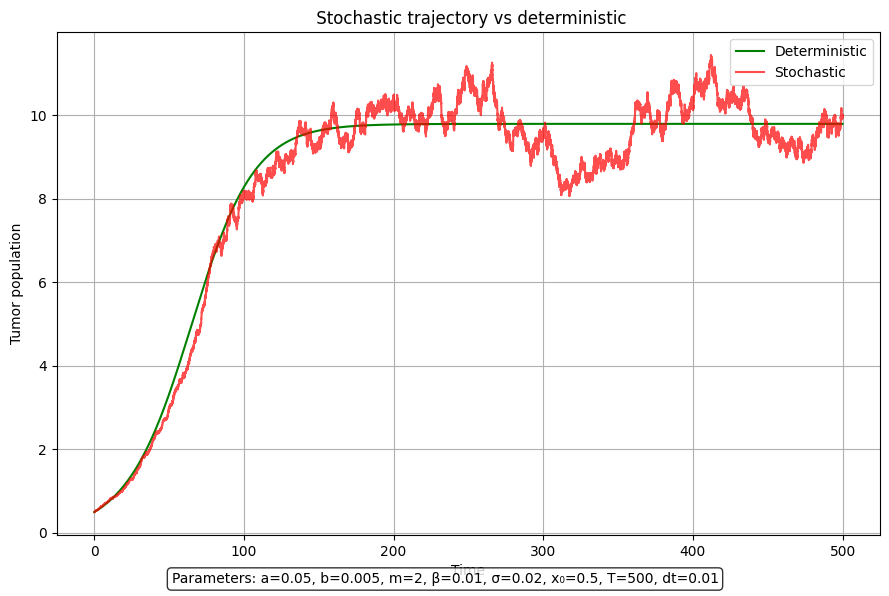

In [213]:
# === FIGURA 3: Traiettoria stocastica vs deterministica ===
T_short = 500
sigma = 0.02
beta = 0.01

t_det, x_det = simulate_deterministic(x0, a, beta, T_short, dt)
t_sto, x_sto = simulate_stochastic(x0, a, beta, sigma, T_short, dt)

plt.figure(figsize=(9, 6))
plt.plot(t_det, x_det, label="Deterministic", color="green")
plt.plot(t_sto, x_sto, label="Stochastic", color="red", alpha=0.7)
plt.title(" Stochastic trajectory vs deterministic")
plt.xlabel("Time")
plt.ylabel("Tumor population")
plt.legend()
plt.grid()
# Aggiungere testo con parametri dentro la figura
param_text = f"Parameters: a={a}, b={b}, m={m}, β={beta}, σ={sigma}, x₀={x0}, T={T_short}, dt={dt}"
plt.figtext(0.5, 0.02, param_text, ha='center', fontsize=10, 
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.subplots_adjust(bottom=0.1)  # Lasciare spazio per il testo
plt.show()
plt.show()

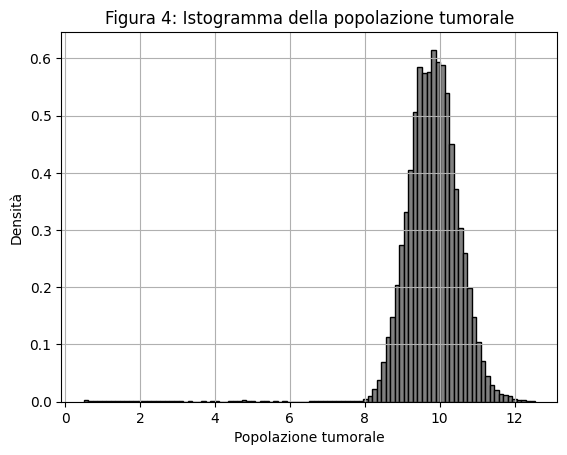

In [214]:
# === FIGURA 4: Istogramma da simulazione lunga ===
T_long = 15000
beta=0.005
sigma = 0.02
_, x_long = simulate_stochastic(x0, a, beta, sigma, T_long, dt)

plt.figure()
plt.hist(x_long, bins=100, density=True, color='gray', edgecolor='black')
plt.title("Figura 4: Istogramma della popolazione tumorale")
plt.xlabel("Popolazione tumorale")
plt.ylabel("Densità")
plt.grid()
plt.show()

In [22]:
print("Min x:", np.min(x_long), "Max x:", np.max(x_long))

Min x: 0.4998786663095132 Max x: 12.011644419716477


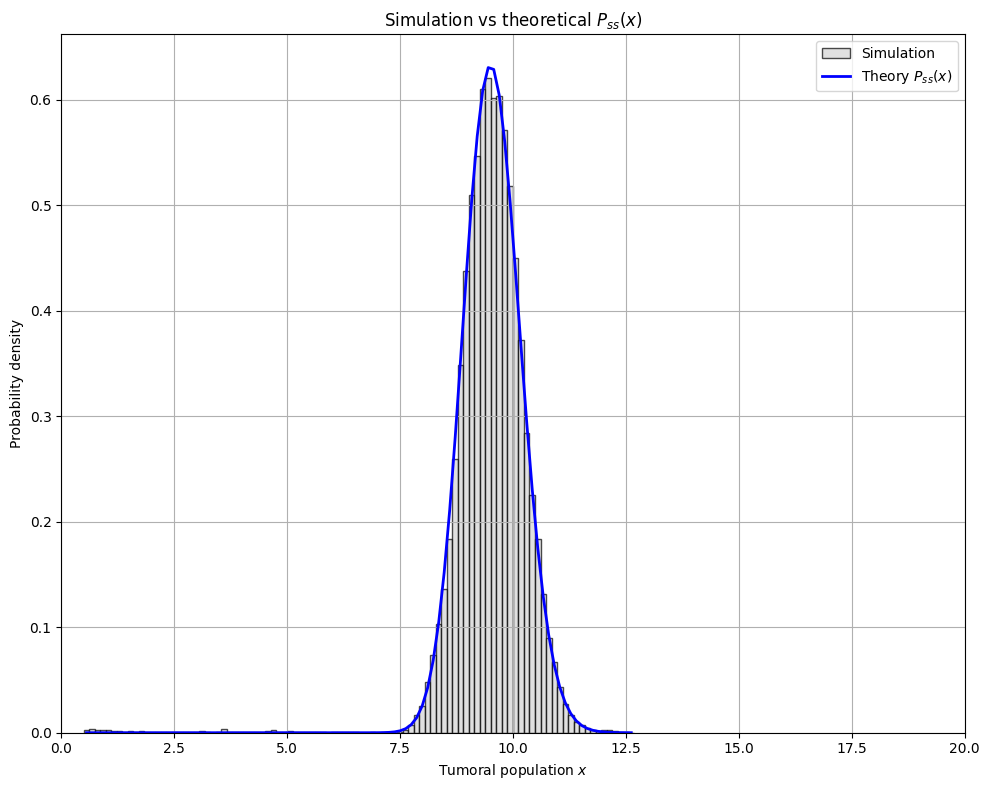

In [256]:
sigma = 0.02
beta= 0.02
# Simulazione
t_long, x_long = simulate_stochastic(x0, a, beta, sigma, T_long, dt)

# Istogramma
counts, bin_edges = np.histogram(x_long, bins=100, density=True)
bin_centers = 0.5*(bin_edges[1:] + bin_edges[:-1])

# Pss sugli stessi punti
pss_on_bins = compute_pss(bin_centers, a, beta, sigma)

# Plot
plt.figure(figsize=(10,8))
plt.hist(x_long, bins=100, density=True, color='lightgray', edgecolor='black', alpha=0.7, label='Simulation')
plt.plot(bin_centers, pss_on_bins, 'b-', linewidth=2, label=r'Theory $P_{ss}(x)$')
plt.xlabel("Tumoral population $x$")
plt.ylabel("Probability density")
plt.title("Simulation vs theoretical $P_{ss}(x)$")
plt.xlim(0, 20)
plt.legend()
plt.grid(True)

# Range dati (tagliare coda rumorosa)

plt.tight_layout()
plt.show()


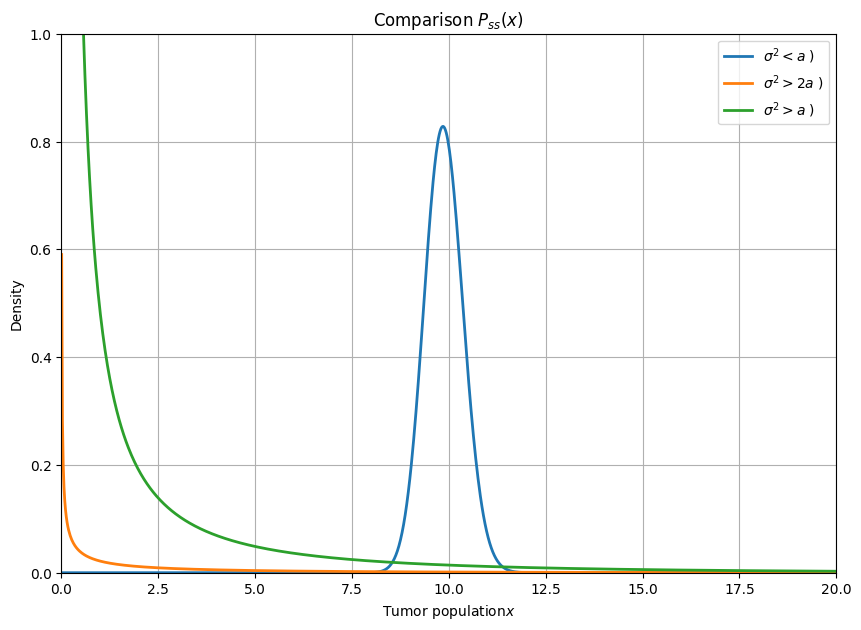

In [215]:
# === Tre casi: sigma^2 < a, ~a, > a ===
sigma_cases = [0.01581,0.2739 ,0.3536 ]   #0.31, 0.22
labels = [r"$\sigma^2 < a$", r"$\sigma^2 > 2a $", r"$\sigma^2 > a$"]
colors = ['tab:blue', 'tab:orange', 'tab:green']

# === Dominio per Pss e bins istogramma (come nel tuo Fig.5) ===
x_min, x_max = 0.01, 20.0
x_vals = np.linspace(x_min, x_max, 1000)
bins = 100  # stesso numero dei tuoi istogrammi
b=0.005
beta=0.005
# === Simula, calcola counts, scala Pss, plottà solo le curve ===
plt.figure(figsize=(10, 7))

for sigma, lab, col in zip(sigma_cases, labels, colors):
    # simulazione lunga
    _, x_long = simulate_stochastic(x0, a, beta, sigma, T_long, dt)
    
    # istogramma solo per ricavare counts (density=True come nel tuo codice)
    counts, bin_edges = np.histogram(x_long, bins=bins,  density=True)
    
    # curva teorica
    pss_vals = compute_pss(x_vals, a, beta, sigma)
    pss_scaled = pss_vals * np.max(counts) / np.max(pss_vals)
    # scaling sui massimi (tuo metodo)
    
    
    # plot SOLO curva scalata
    plt.plot(x_vals, pss_scaled, color=col, linewidth=2,
             label=f"{lab} )")

plt.title(r"Comparison $P_{ss}(x)$ ")
plt.xlabel("Tumor population$x$")
plt.ylabel(r"Density")
plt.ylim(0,1)
plt.xlim(0, x_max)
plt.legend()
plt.grid(True)
plt.show()

In [156]:
print(b)

0.005


In [168]:




def hitting_time(x0, a, beta, sigma, epsilon, dt, Tmax):
    t = 0.0
    x = x0
    while x > epsilon and t < Tmax:
        dw = np.random.normal(0, np.sqrt(dt))
        x += drift(x, a, beta) * dt + diffusion(x, sigma) * dw
        x = max(x, 0)
        t += dt
    return t

def simulate_hitting_times(sigmas, x0, a, beta, epsilon, dt, Tmax, n_sim):
    mean_times = []
    for sigma in sigmas:
        times = []
        for _ in range(n_sim):
            tau = hitting_time(x0, a, beta, sigma, epsilon, dt, Tmax)
            times.append(tau)
        mean_times.append(np.mean(times))
    return mean_times


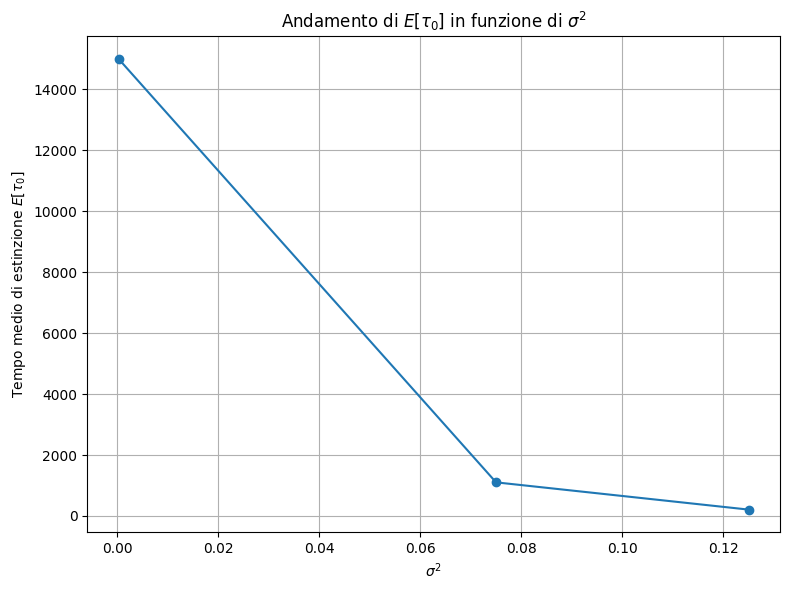

In [171]:
a = 0.05
b = 0.005
m = 2
x0 = a / 0.1   # ad esempio partiamo dall'equilibrio deterministico (a/beta)
beta = 0.1
dt = 0.01
epsilon = 1e-3
Tmax = 15000   # limite massimo tempo per sicurezza
n_sim = 200

sigmas = np.array([0.01581,0.2739 ,0.3536])  # scegli range sensato
mean_tau = simulate_hitting_times(sigmas, x0, a, beta, epsilon, dt, Tmax, n_sim)

# === Plot E[τ₀] vs σ² ===
plt.figure(figsize=(8, 6))
plt.plot(sigmas**2, mean_tau, marker='o', color='tab:blue')
plt.xlabel(r'$\sigma^2$')
plt.ylabel(r'Tempo medio di estinzione $E[\tau_0]$')
plt.title(r'Andamento di $E[\tau_0]$ in funzione di $\sigma^2$')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def estimate_mfpt_markov(x_min, x_max, dx, a, beta, sigma, epsilon):
    x_vals = np.arange(x_min, x_max + dx, dx)
    N = len(x_vals)
    dx2 = dx * dx

    D = diffusion(x_vals, sigma)**2 / 2
    mu = drift(x_vals, a, beta)

    A = np.zeros((N, N))

    for i in range(1, N - 1):
        if D[i] < 1e-10:
            D[i] = 1e-10  # Stabilizzazione
        A[i, i - 1] = (D[i] / dx2) - (mu[i] / (2 * dx))
        A[i, i] = -2 * D[i] / dx2
        A[i, i + 1] = (D[i] / dx2) + (mu[i] / (2 * dx))

    A[0, 0] = 1   # Stato assorbente
    A[-1, -1] = 1  # Bordo superiore: riflettente

    b = np.ones(N)
    b[0] = 0
    b[-1] = 0

    try:
        tau = np.linalg.solve(-A, b)
    except np.linalg.LinAlgError:
        tau = np.full(N, np.nan)

    return x_vals, tau


📉 Tau eccessivo (7.2e+12) per σ²=0.0002


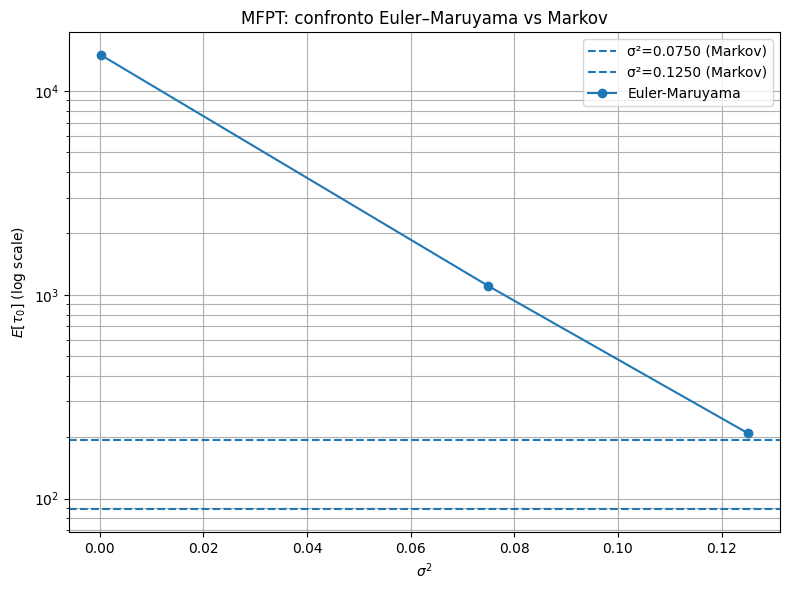

In [180]:
MAX_TAU = 1e6
dx = 0.005
x_min = epsilon
x_max = 1.5

plt.figure(figsize=(8, 6))

for sigma in sigmas:
    x_vals, tau_markov = estimate_mfpt_markov(x_min, x_max, dx, a, beta, sigma, epsilon)
    idx_start = np.argmin(np.abs(x_vals - x0))
    tau_val = tau_markov[idx_start]

    if np.isnan(tau_val):
        print(f"📛 NaN per σ²={sigma**2:.4f}")
    elif tau_val > MAX_TAU:
        print(f"📉 Tau eccessivo ({tau_val:.1e}) per σ²={sigma**2:.4f}")
    else:
        plt.axhline(tau_val, linestyle='--', label=fr'σ²={sigma**2:.4f} (Markov)')

plt.plot(sigmas**2, mean_tau, marker='o', color='tab:blue', label='Euler-Maruyama')
plt.yscale('log')
plt.xlabel(r'$\sigma^2$')
plt.ylabel(r'$E[\tau_0]$ (log scale)')
plt.title('MFPT: confronto Euler–Maruyama vs Markov')
plt.legend()
plt.grid(True, which="both")
plt.tight_layout()
plt.show()


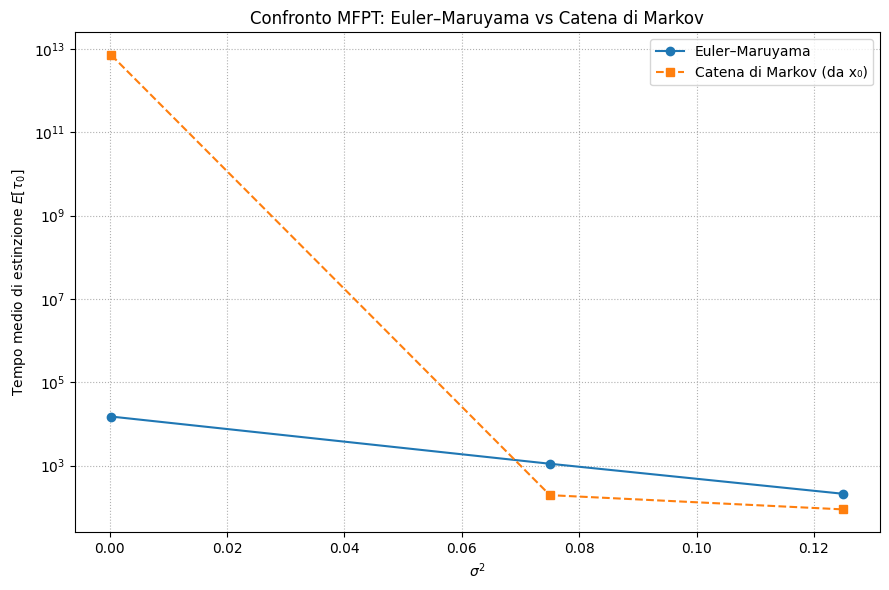

In [ ]:
# === Parametri per Markov ===
dx = 0.005
x_min = epsilon
x_max = 1.5

# === Calcolo MFPT con catena di Markov ===
tau_markov_list = []

for sigma in sigmas:
    x_vals, tau_markov = estimate_mfpt_markov(x_min, x_max, dx, a, beta, sigma, epsilon)
    idx_start = np.argmin(np.abs(x_vals - x0))
    tau_val = tau_markov[idx_start]

    if np.isnan(tau_val):
        print(f"⚠️ Tau Markov NaN per σ² = {sigma**2:.4f}")
        tau_val = np.nan
    tau_markov_list.append(tau_val)

# === Plot confronto completo ===
plt.figure(figsize=(9, 6))

# Curve simulazione Euler–Maruyama
plt.plot(sigmas**2, mean_tau, 'o-', color='tab:blue', label='Euler–Maruyama')

# Curve catena di Markov
plt.plot(sigmas**2, tau_markov_list, 's--', color='tab:orange', label='Catena di Markov (da x₀)')

# Log scale per evidenziare ordini di grandezza
plt.yscale('log')

# Etichette e dettagli
plt.xlabel(r'$\sigma^2$')
plt.ylabel(r'Tempo medio di estinzione $E[\tau_0]$')
plt.title(r'Confronto MFPT: Euler–Maruyama vs Catena di Markov')
plt.grid(True, which='both', linestyle=':')
plt.legend()
plt.tight_layout()
plt.show()


In [234]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz

# === PARAMETRI DEL MODELLO ===
a = 0.05
b = 0.005
m = 2
beta = 0.01
x0 = 0.5
dt = 0.01
Tmax = 20000
n_sim = 200
epsilon = 1e-3

# === Drift e Diffusione ===
def drift(x):
    return (a - b * x**(m - 1)) * x - (beta * x**2) / (1 + x**2)

def diffusion(x, sigma):
    return sigma * x

# === Simulazione tempo di hitting ===
def hitting_time(x0, sigma, epsilon, dt, Tmax):
    t = 0.0
    x = x0
    while x > epsilon and t < Tmax:
        dw = np.random.normal(0, np.sqrt(dt))
        x += drift(x) * dt + diffusion(x, sigma) * dw
        x = max(x, 0)
        t += dt
    return t

def simulate_hitting_times(sigmas, x0, epsilon, dt, Tmax, n_sim):
    mean_times = []
    for sigma in sigmas:
        print(f"Simulazioni per σ = {sigma:.4f}")
        times = [hitting_time(x0, sigma, epsilon, dt, Tmax) for _ in range(n_sim)]
        mean_times.append(np.mean(times))
    return mean_times

# === Calcolo della funzione ausiliaria ψ(x) ===
def compute_psi(x, sigma):
    integrand = 2 * drift(x) / (diffusion(x, sigma)**2 + 1e-12)
    U = cumtrapz(integrand, x, initial=0)
    return np.exp(U)

# === MFPT teorico tramite quadratura ===
# === Calcolo della funzione ausiliaria ψ(x) con stabilizzazione ===
def compute_psi(x, sigma):
    integrand = 2 * drift(x) / (diffusion(x, sigma)**2 + 1e-12)
    U = cumtrapz(integrand, x, initial=0)
    U -= np.max(U)  # riduzione overflow
    return np.exp(U)

# === MFPT teorico con stabilizzazione numerica ===
def mfpt_quadrature(x0, sigma, epsilon=1e-3, x_max=2.0, N=2000):
    x = np.linspace(epsilon, x_max, N)
    psi = compute_psi(x, sigma)
    G2 = diffusion(x, sigma)**2

    # Primo integrale interno (da y a x_max)
    inner_integral = np.zeros_like(x)
    for i in range(len(x)):
        y = (2.0 / (G2[i:] + 1e-12)) * psi[i:]
        y = np.clip(y, 1e-300, 1e300)
        inner_integral[i] = np.trapz(y, x[i:])

    # Trova indice corrispondente a x0
    idx0 = np.searchsorted(x, x0)
    x_cut = x[:idx0 + 1]
    psi_cut = psi[:idx0 + 1]
    inner_cut = inner_integral[:idx0 + 1]

    # Integrale esterno (da ε a x0)
    z = (1.0 / (psi_cut + 1e-12)) * inner_cut
    z = np.clip(z, 1e-300, 1e300)
    T = np.trapz(z, x_cut)
    return T




In [ ]:
import numpy as np

# Rendi tutto array per filtrare facilmente
sigmas = np.array(sigmas)
mean_tau_sim = np.array(mean_tau_sim)
mean_tau_med = np.array(median_tau_sim)
mean_tau_quad = np.array(mean_tau_quad)

# Filtro: tieni solo dove la soluzione teorica è valida
valid_mask = ~np.isnan(mean_tau_quad)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(sigmas[valid_mask], mean_tau_sim[valid_mask], 'o-', label='Mean (EM simulation)')
plt.plot(sigmas[valid_mask], mean_tau_med[valid_mask], 'x--', label='Median (EM simulation)')
plt.plot(sigmas[valid_mask], mean_tau_quad[valid_mask], 's-.', label='Analytical via quadrature')
plt.xlabel(r'$\sigma$')
plt.ylabel(r'$\tau$')
plt.title(r'Mean First Passage Time vs $\sigma$ - Mean, Median, and Theory')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Sigmas: [0.02 0.1  0.3  0.5 ]
Tau teorici (via quadrature): [nan, 816.460272277374, 791.1738006812215, 2578.618925964389]


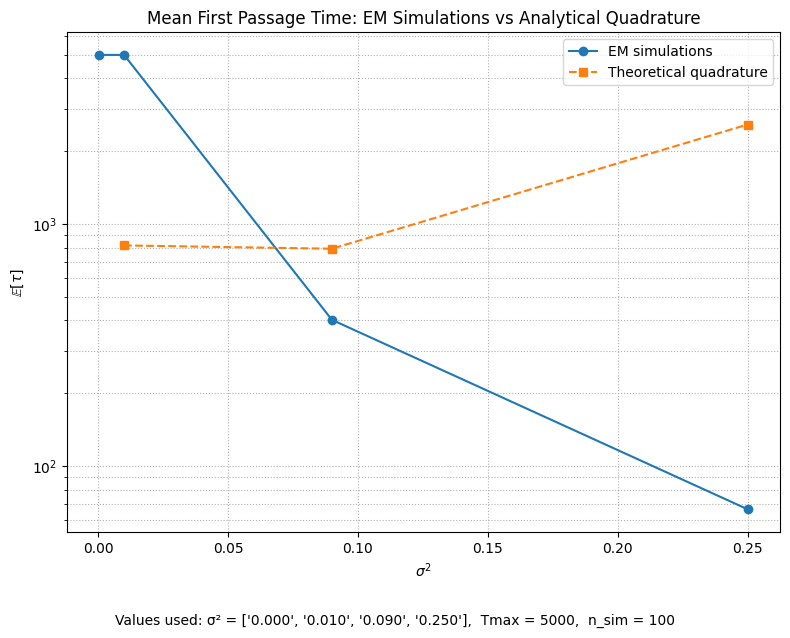

In [242]:

plt.figure(figsize=(8, 6))
plt.plot(sigmas**2, mean_tau_sim, 'o-', label=r'EM simulations')
plt.plot(sigmas**2, mean_tau_quad, 's--', label=r'Theoretical quadrature')

# No log scale on x-axis
plt.yscale('log')
plt.xlabel(r"$\sigma^2$")
plt.ylabel(r"$\mathbb{E}[\tau]$")
plt.title(r'Mean First Passage Time: EM Simulations vs Analytical Quadrature')
plt.grid(True, which='both', linestyle=':')
plt.legend()
plt.tight_layout()

# Caption below the plot
caption = f"Values used: σ² = {[f'{s**2:.3f}' for s in sigmas]},  Tmax = {Tmax},  n_sim = {n_sim}"
plt.figtext(0.5, -0.05, caption, wrap=True, horizontalalignment='center', fontsize=10)

plt.show()


Simulazioni per σ = 0.0200
Simulazioni per σ = 0.1000
Simulazioni per σ = 0.3000
Simulazioni per σ = 0.5000


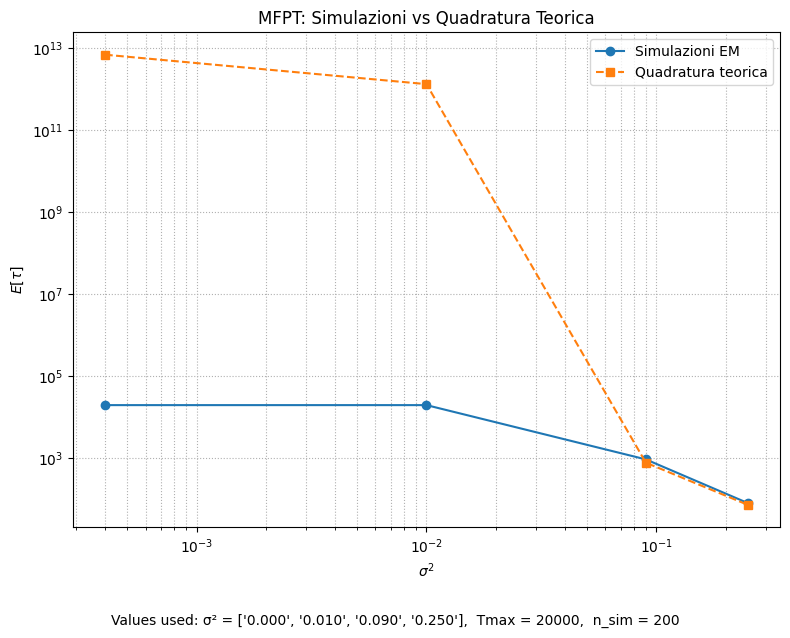

In [235]:
sigmas = np.array([0.02, 0.1, 0.3, 0.5])
mean_tau_sim = simulate_hitting_times(sigmas, x0, epsilon, dt, Tmax, n_sim)
mean_tau_quad = [mfpt_quadrature(x0, s) for s in sigmas]

plt.figure(figsize=(8, 6))
plt.plot(sigmas**2, mean_tau_sim, 'o-', label=r'Simulazioni EM')
plt.plot(sigmas**2, mean_tau_quad, 's--', label=r'Quadratura teorica')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\sigma^2$")
plt.ylabel(r"$E[\tau]$")
plt.title(r'MFPT: Simulazioni vs Quadratura Teorica')
plt.legend()
plt.grid(True, which='both', linestyle=':')
plt.tight_layout()


# Caption below the plot
caption = f"Values used: σ² = {[f'{s**2:.3f}' for s in sigmas]},  Tmax = {Tmax},  n_sim = {n_sim}"
plt.figtext(0.5, -0.05, caption, wrap=True, horizontalalignment='center', fontsize=10)

plt.show()

σ=0.020, Hit fraction=0.00, Mean τ=500.0
σ=0.100, Hit fraction=0.00, Mean τ=500.0
σ=0.300, Hit fraction=0.36, Mean τ=411.4
σ=0.500, Hit fraction=1.00, Mean τ=82.2


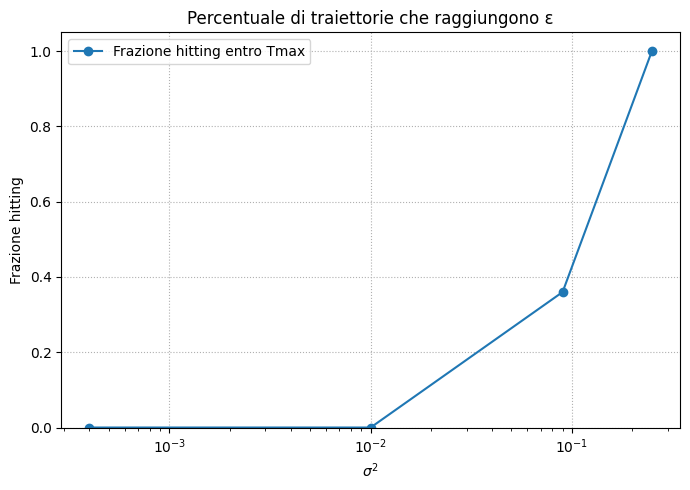

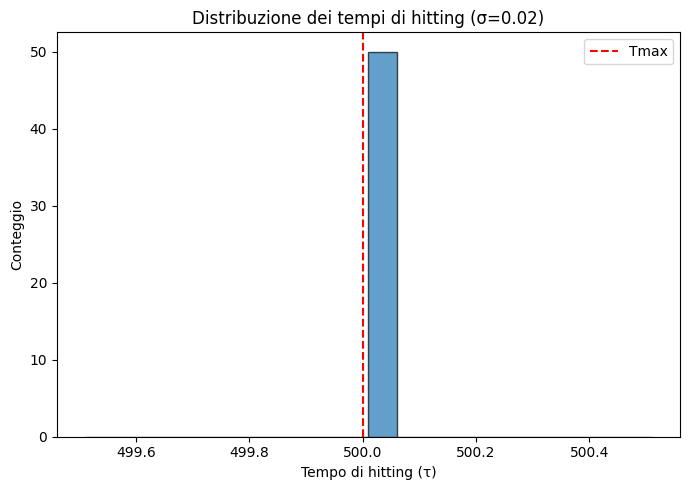

In [249]:
import numpy as np
import matplotlib.pyplot as plt

# === PARAMETRI ===
a = 0.05
b = 0.005
m = 2
beta = 0.01
x0 = 0.5
dt = 0.01
Tmax = 500
n_sim = 50
epsilon = 1e-3
sigmas = np.array([0.02, 0.1, 0.3, 0.5])

# Drift e diffusione
def drift(x):
    return (a - b * x**(m - 1)) * x - (beta * x**2) / (1 + x**2)

def diffusion(x, sigma):
    return sigma * x

# Simulazione tempo di hitting
def hitting_time(x0, sigma, epsilon, dt, Tmax):
    t = 0.0
    x = x0
    while x > epsilon and t < Tmax:
        dw = np.random.normal(0, np.sqrt(dt))
        x += drift(x) * dt + diffusion(x, sigma) * dw
        x = max(x, 0)
        t += dt
    return t, x <= epsilon  # ritorna anche se ha colpito epsilon

def simulate_hitting_times(sigmas, x0, epsilon, dt, Tmax, n_sim):
    mean_times = []
    hit_fractions = []
    all_times = {sigma: [] for sigma in sigmas}
    
    for sigma in sigmas:
        times = []
        hits = 0
        for _ in range(n_sim):
            t, hit = hitting_time(x0, sigma, epsilon, dt, Tmax)
            times.append(t)
            if hit:
                hits += 1
        hit_fraction = hits / n_sim
        hit_fractions.append(hit_fraction)
        mean_times.append(np.mean(times))
        all_times[sigma] = times
        print(f"σ={sigma:.3f}, Hit fraction={hit_fraction:.2f}, Mean τ={np.mean(times):.1f}")
    return mean_times, hit_fractions, all_times

mean_tau_sim, hit_fractions, all_times = simulate_hitting_times(sigmas, x0, epsilon, dt, Tmax, n_sim)

# === GRAFICO 1: FRAZIONE DI HITTING vs SIGMA² ===
plt.figure(figsize=(7,5))
plt.plot(sigmas**2, hit_fractions, 'o-', label="Frazione hitting entro Tmax")
plt.xscale('log')
plt.xlabel(r"$\sigma^2$")
plt.ylabel("Frazione hitting")
plt.ylim(0,1.05)
plt.grid(True, linestyle=':')
plt.title("Percentuale di traiettorie che raggiungono ε")
plt.legend()
plt.tight_layout()
plt.show()

# === GRAFICO 2: ISTOGRAMMA DEI TEMPI per σ=0.02 ===
sigma_test = 0.02
plt.figure(figsize=(7,5))
plt.hist(all_times[sigma_test], bins=20, alpha=0.7, edgecolor='k')
plt.axvline(Tmax, color='r', linestyle='--', label='Tmax')
plt.xlabel("Tempo di hitting (τ)")
plt.ylabel("Conteggio")
plt.title(f"Distribuzione dei tempi di hitting (σ={sigma_test})")
plt.legend()
plt.tight_layout()
plt.show()


C:\Users\ritao\AppData\Local\Temp\ipykernel_27264\1125620237.py:58: RuntimeWarning: divide by zero encountered in log
  plt.plot(inv_sigma_sq[valid], np.log(mean_tau_sim[valid]), 'o-', label='log E[τ] (EM simulation)')


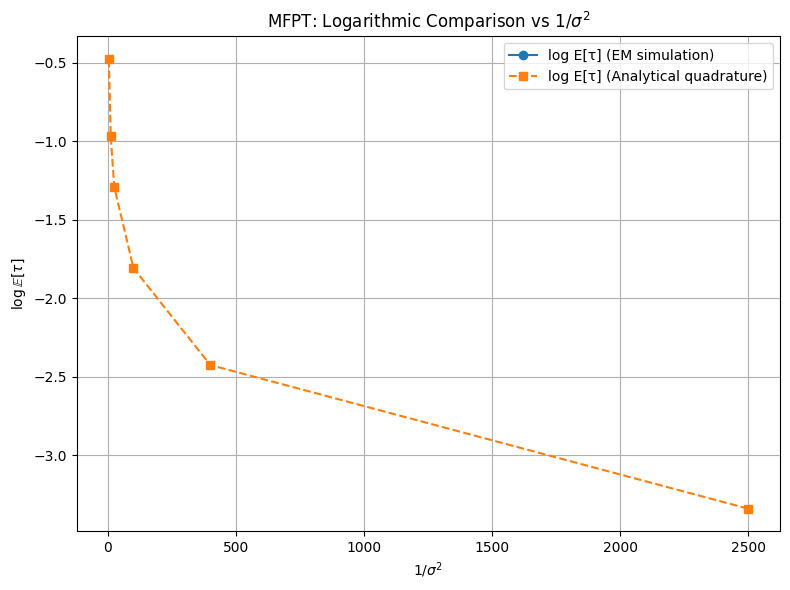

In [246]:
import numpy as np
import matplotlib.pyplot as plt

# Parametri
sigmas = np.array([0.02, 0.05, 0.1, 0.2, 0.3, 0.5])
x0 = -1
epsilon = 0.1
dt = 0.01
Tmax = 2000
n_sim = 200

# Funzione simulazione EM
def simulate_hitting_times(sigmas, x0, epsilon, dt, Tmax, n_sim):
    tau_means = []
    for sigma in sigmas:
        taus = []
        for _ in range(n_sim):
            x = x0
            t = 0
            while abs(x) < epsilon and t < Tmax:
                x += -x * dt + sigma * np.sqrt(dt) * np.random.randn()
                t += 1
            taus.append(t * dt if abs(x) >= epsilon else Tmax)
        tau_means.append(np.mean(taus))
    return np.array(tau_means)

# Funzione quadratura teorica
from scipy.integrate import quad

def mfpt_quadrature(x0, sigma):
    def V(x):
        return 0.5 * x**2  # Potenziale armonico

    def integrand(x):
        def inner(y):
            return np.exp(2 * (V(y) - V(x0)) / sigma**2)
        inner_integral, _ = quad(inner, x0, x)
        return inner_integral * np.exp(-2 * V(x) / sigma**2)
    
    try:
        integral, _ = quad(integrand, x0, epsilon)
        return (2 / sigma**2) * integral
    except:
        return np.nan

# Calcoli
mean_tau_sim = simulate_hitting_times(sigmas, x0, epsilon, dt, Tmax, n_sim)
mean_tau_quad = np.array([mfpt_quadrature(x0, s) for s in sigmas])

# Calcolo asse x
inv_sigma_sq = 1 / sigmas**2

# Filtra per validi (no nan)
valid = ~np.isnan(mean_tau_quad)

# Plot logaritmico
plt.figure(figsize=(8, 6))
plt.plot(inv_sigma_sq[valid], np.log(mean_tau_sim[valid]), 'o-', label='log E[τ] (EM simulation)')
plt.plot(inv_sigma_sq[valid], np.log(mean_tau_quad[valid]), 's--', label='log E[τ] (Analytical quadrature)')
plt.xlabel(r'$1/\sigma^2$')
plt.ylabel(r'$\log \mathbb{E}[\tau]$')
plt.title('MFPT: Logarithmic Comparison vs $1/\sigma^2$')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


σ=0.020 → E[τ]=2000.01, hit%=0.0%
σ=0.100 → E[τ]=2000.01, hit%=0.0%
σ=0.300 → E[τ]=878.21, hit%=89.0%
σ=0.500 → E[τ]=80.83, hit%=100.0%


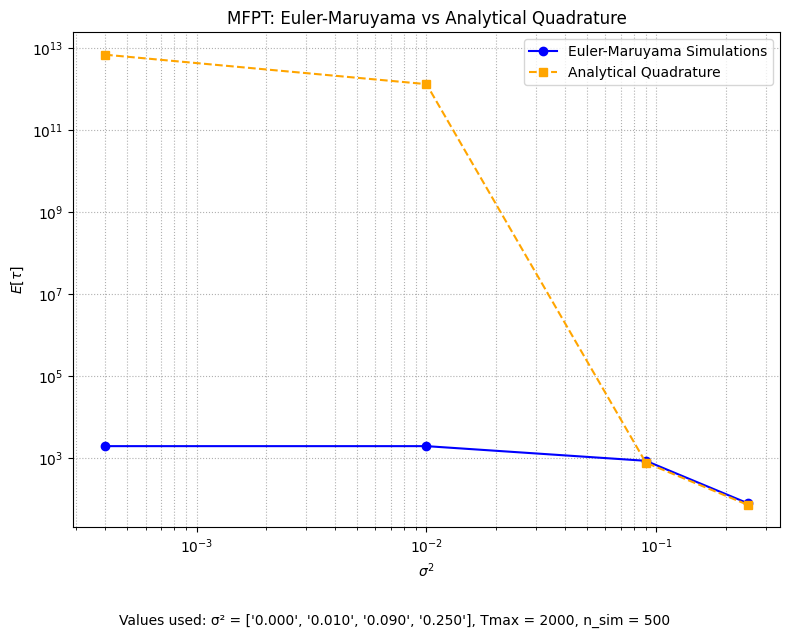

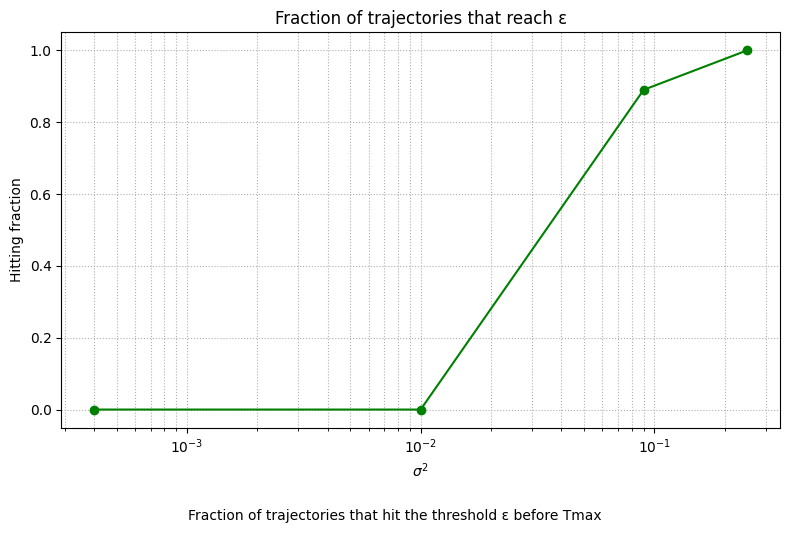

In [253]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import cumtrapz

# === PARAMETRI DEL MODELLO ===
a = 0.05
b = 0.005
m = 2
beta = 0.01
x0 = 0.5
dt = 0.01
Tmax = 2000
n_sim = 500
epsilon = 1e-3

# === Drift e Diffusione ===
def drift(x):
    return (a - b * x**(m - 1)) * x - (beta * x**2) / (1 + x**2)

def diffusion(x, sigma):
    return sigma * x

# === Simulazione tempo di hitting ===
def hitting_time(x0, sigma, epsilon, dt, Tmax):
    t = 0.0
    x = x0
    while x > epsilon and t < Tmax:
        dw = np.random.normal(0, np.sqrt(dt))
        x += drift(x) * dt + diffusion(x, sigma) * dw
        x = max(x, 0)
        t += dt
    return t, (x <= epsilon)

def simulate_hitting_times(sigmas, x0, epsilon, dt, Tmax, n_sim):
    mean_times = []
    hit_fractions = []
    for sigma in sigmas:
        times = []
        hits = 0
        for _ in range(n_sim):
            t, hit = hitting_time(x0, sigma, epsilon, dt, Tmax)
            times.append(t)
            if hit:
                hits += 1
        mean_times.append(np.mean(times))
        hit_fractions.append(hits / n_sim)
        print(f"σ={sigma:.3f} → E[τ]={mean_times[-1]:.2f}, hit%={hit_fractions[-1]*100:.1f}%")
    return mean_times, hit_fractions

# === Calcolo della funzione ausiliaria ψ(x) ===
def compute_psi(x, sigma):
    integrand = 2 * drift(x) / (diffusion(x, sigma)**2 + 1e-12)
    U = cumtrapz(integrand, x, initial=0)
    U -= np.max(U)  # riduzione overflow
    return np.exp(U)

# === MFPT teorico ===
def mfpt_quadrature(x0, sigma, epsilon=1e-3, x_max=2.0, N=2000):
    x = np.linspace(epsilon, x_max, N)
    psi = compute_psi(x, sigma)
    G2 = diffusion(x, sigma)**2

    inner_integral = np.zeros_like(x)
    for i in range(len(x)):
        y = (2.0 / (G2[i:] + 1e-12)) * psi[i:]
        y = np.clip(y, 1e-300, 1e300)
        inner_integral[i] = np.trapz(y, x[i:])

    idx0 = np.searchsorted(x, x0)
    x_cut = x[:idx0 + 1]
    psi_cut = psi[:idx0 + 1]
    inner_cut = inner_integral[:idx0 + 1]

    z = (1.0 / (psi_cut + 1e-12)) * inner_cut
    z = np.clip(z, 1e-300, 1e300)
    T = np.trapz(z, x_cut)
    return T

# === ESECUZIONE ===
sigmas = np.array([0.02, 0.1, 0.3, 0.5])
mean_tau_sim, hit_fractions = simulate_hitting_times(sigmas, x0, epsilon, dt, Tmax, n_sim)
mean_tau_quad = [mfpt_quadrature(x0, s) for s in sigmas]

# === GRAFICO A: MFPT ===

# === PLOT A: MFPT (with line connections) ===
plt.figure(figsize=(8, 6))
plt.plot(sigmas**2, mean_tau_sim, '-o', color='blue', label='Euler-Maruyama Simulations')
plt.plot(sigmas**2, mean_tau_quad, '--s', color='orange', label='Analytical Quadrature')

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r"$\sigma^2$")
plt.ylabel(r"$E[\tau]$")
plt.title('MFPT: Euler-Maruyama vs Analytical Quadrature')
plt.legend()
plt.grid(True, which='both', linestyle=':')
plt.tight_layout()

caption = f"Values used: σ² = {[f'{s**2:.3f}' for s in sigmas]}, Tmax = {Tmax}, n_sim = {n_sim}"
plt.figtext(0.5, -0.05, caption, wrap=True, horizontalalignment='center', fontsize=10)
plt.show()

# === PLOT B: Hitting fraction ===
plt.figure(figsize=(8, 5))
plt.plot(sigmas**2, hit_fractions, 'o-', color='green')
plt.xscale('log')
plt.xlabel(r"$\sigma^2$")
plt.ylabel("Hitting fraction")
plt.title("Fraction of trajectories that reach ε")
plt.grid(True, which='both', linestyle=':')
plt.tight_layout()
plt.figtext(0.5, -0.05, "Fraction of trajectories that hit the threshold ε before Tmax", wrap=True, horizontalalignment='center', fontsize=10)
plt.show()
